In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score
import seaborn as sns

Check if notebook is running locally or on kaggle/colab

In [15]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("os.environ.get('KAGGLE_URL_BASE') == ", os.environ.get('KAGGLE_URL_BASE'))
if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    print("We are running on a Kaggle Server")
    IN_KAGGLE = True
else:
    IN_KAGGLE = False

os.environ.get('KAGGLE_URL_BASE') ==  None


In [14]:
print(IN_COLAB)
print(IN_KAGGLE)

False


# House price regression using TensorFlow

I have to: 

1) load the data

2) apply some basic feature engineering and cleaning

3) encode and normalize the data into something that can be efficiently computed by tensorflow

4) train the model, score it and compute metrics

5) check the model predictions visually

6) predict the house prices in the test set

Fore more info:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

https://www.tensorflow.org/tutorials/load_data/csv

https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?authuser=2

https://www.tensorflow.org/guide/keras/preprocessing_layers

In [2]:
if not IN_COLAB and not IN_KAGGLE:
    from house_prices_script import feat_eng
else:
    def feat_eng(df):
        ''' performs dataframe cleaning and basic feature engineering'''
        #total floors
        df['TotFlrSF']=df['1stFlrSF']+df['2ndFlrSF']
        #total number of floors (1 or 2)
        df['nFlrs']=df['2ndFlrSF'].map(lambda x: int(x>0)+1.)#if df['2ndFlrSF']>0 then df['nFlrs']=2
        df['GarageType']=df['GarageType'].fillna('NoGarage')
        df['GarageQual']=df['GarageQual'].fillna('NoGarage')
        df['GarageCond']=df['GarageCond'].fillna('NoGarage')
        df['PoolQC']=df['PoolQC'].fillna('NoPool')
        df['FireplaceQu']=df['FireplaceQu'].fillna('NoFp')
        #garage cars vs house size
        #number of bathrooms vs house size/n bedrooms
        return df

Load data:

In [ ]:
if(IN_KAGGLE):
    train_path='../input/house-prices-advanced-regression-techniques/train.csv'
else:
    train_path='./train.csv'

In [16]:
train=pd.read_csv(train_path).drop([523,1298])

In [4]:
int_cat_f=['SaleCondition','ExterQual','Neighborhood','KitchenQual','SaleType','PoolQC','MSZoning','GarageQual','Condition1','BldgType','FireplaceQu','GarageType']
int_num_f=['OverallQual','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea','YearBuilt','GarageCars','TotRmsAbvGrd','MSSubClass','WoodDeckSF','YearRemodAdd']


In [5]:
label='SalePrice'

In [10]:
plot=False

SaleCondition


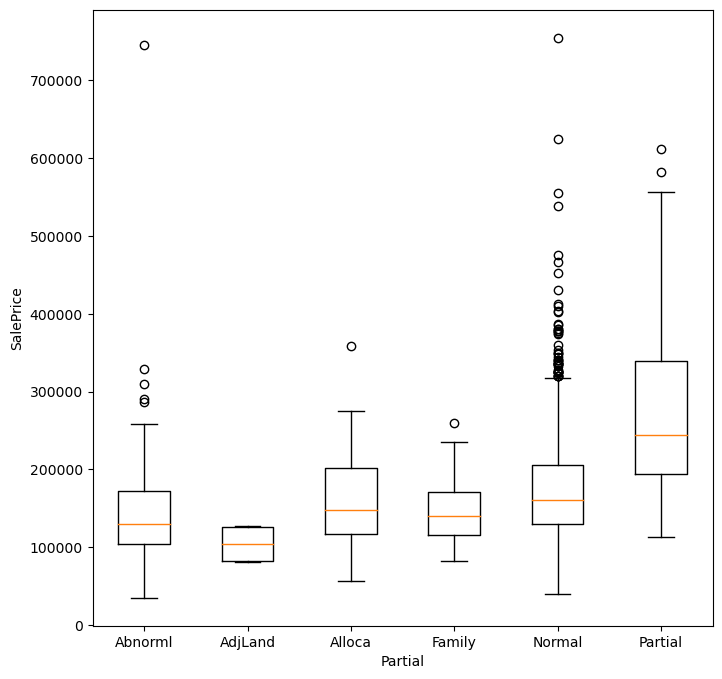

ExterQual


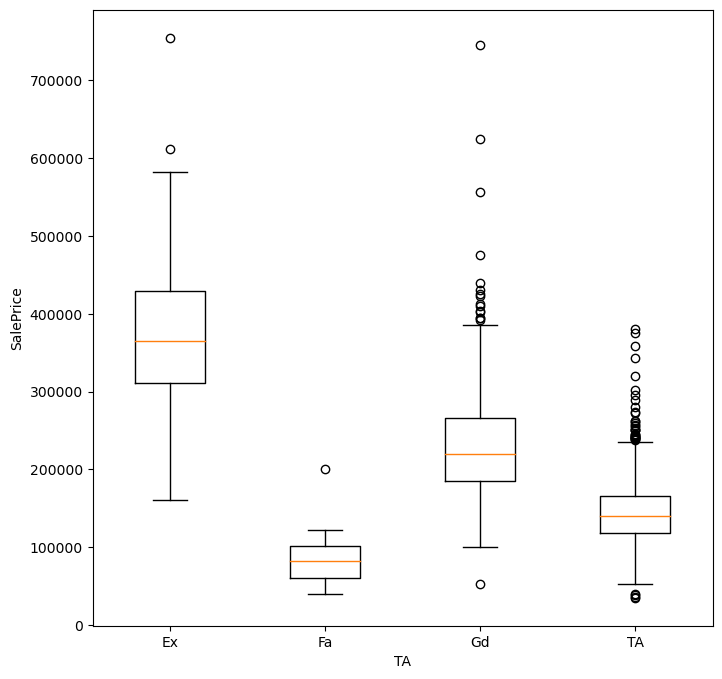

Neighborhood


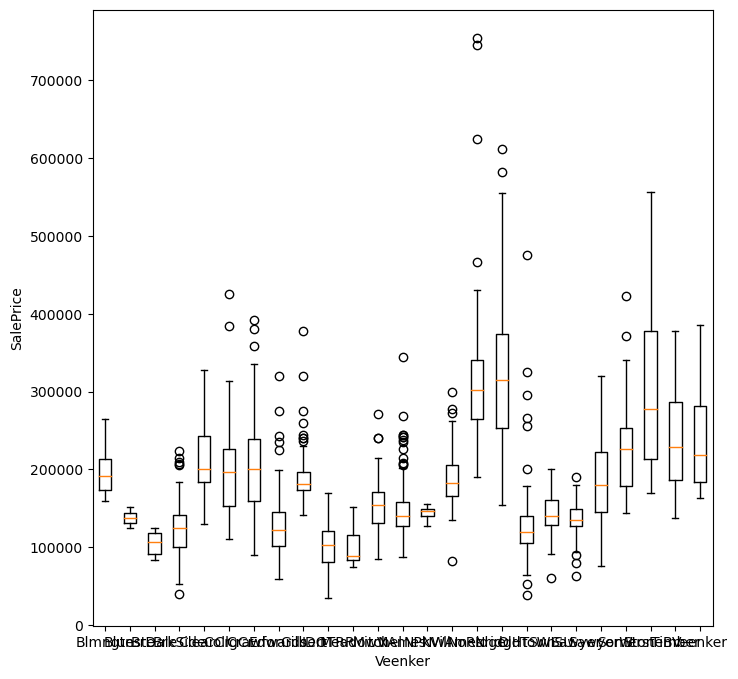

KitchenQual


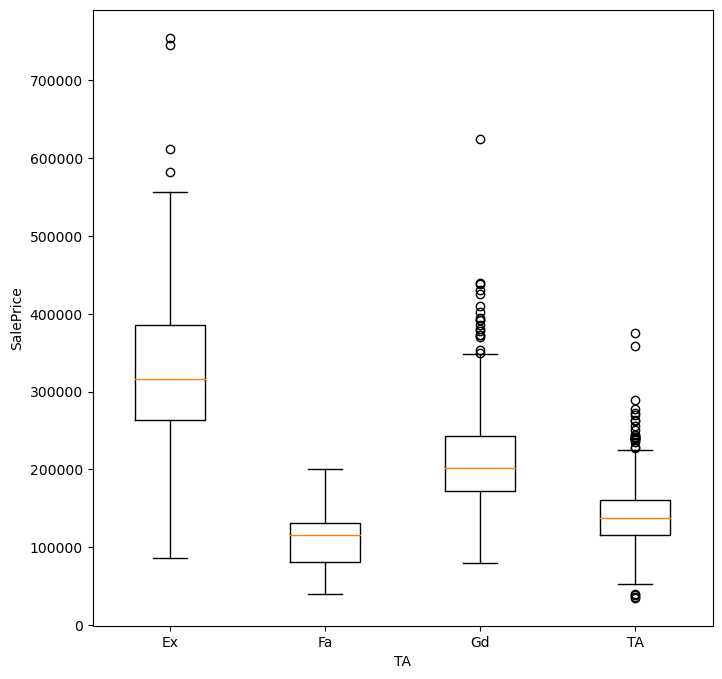

SaleType


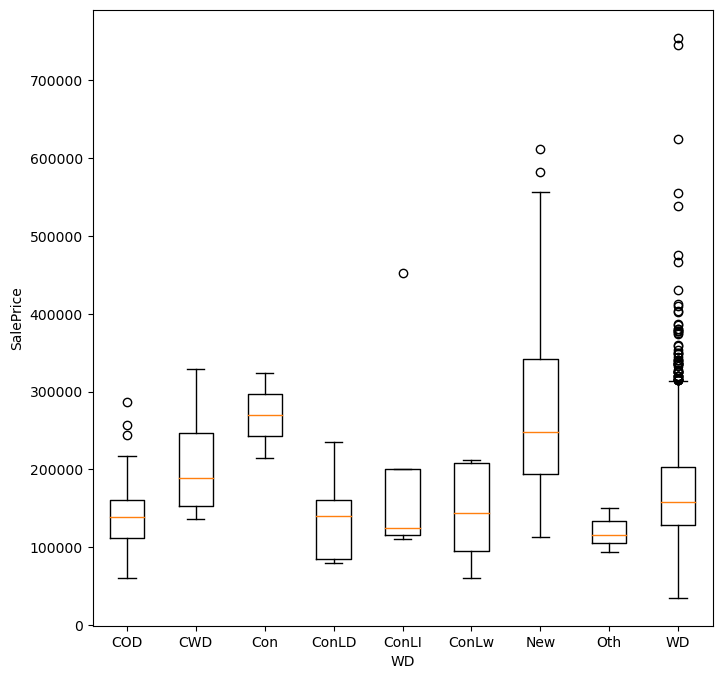

PoolQC


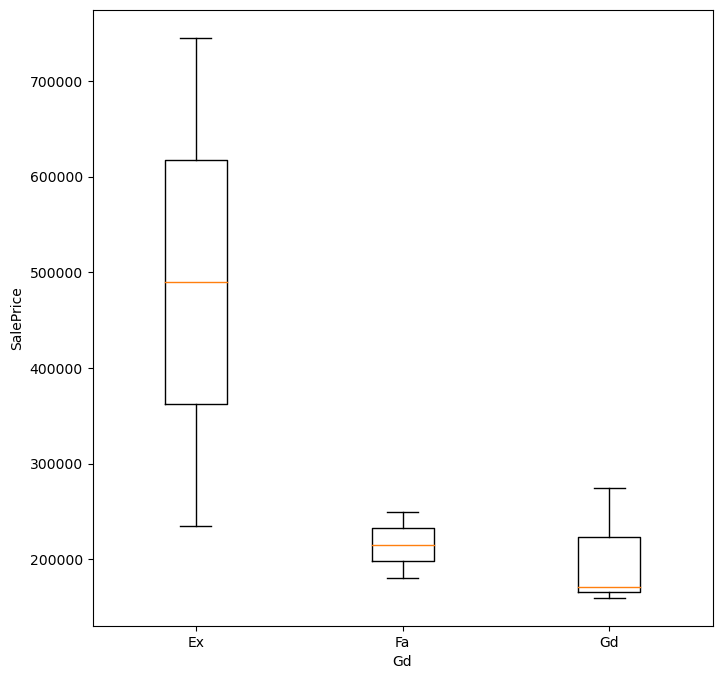

MSZoning


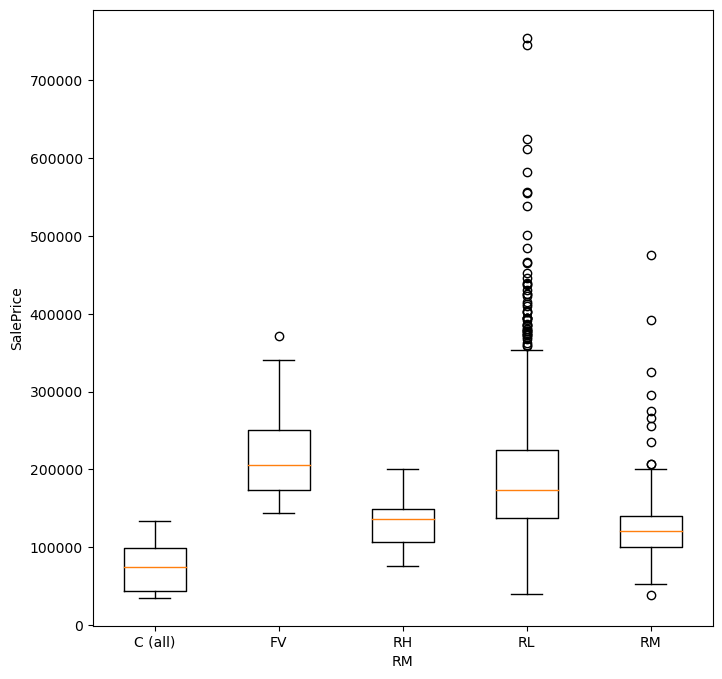

GarageQual


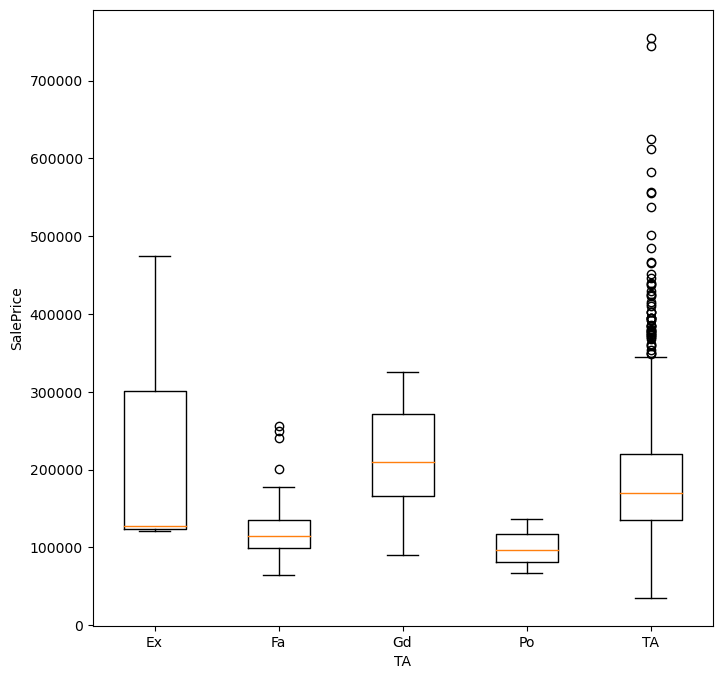

Condition1


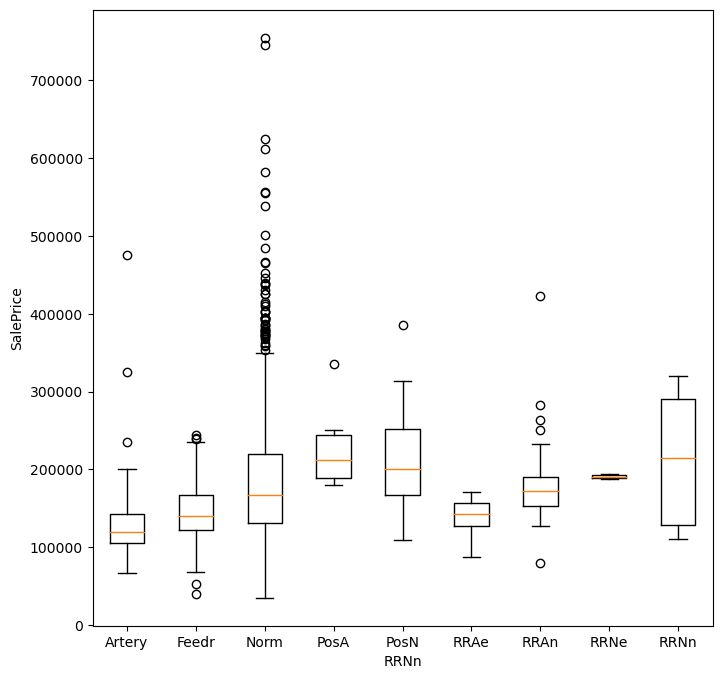

BldgType


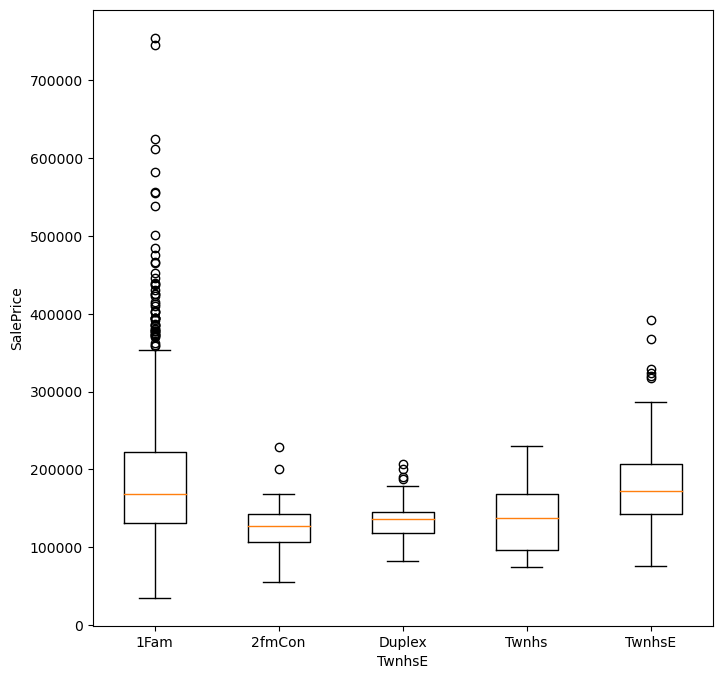

FireplaceQu


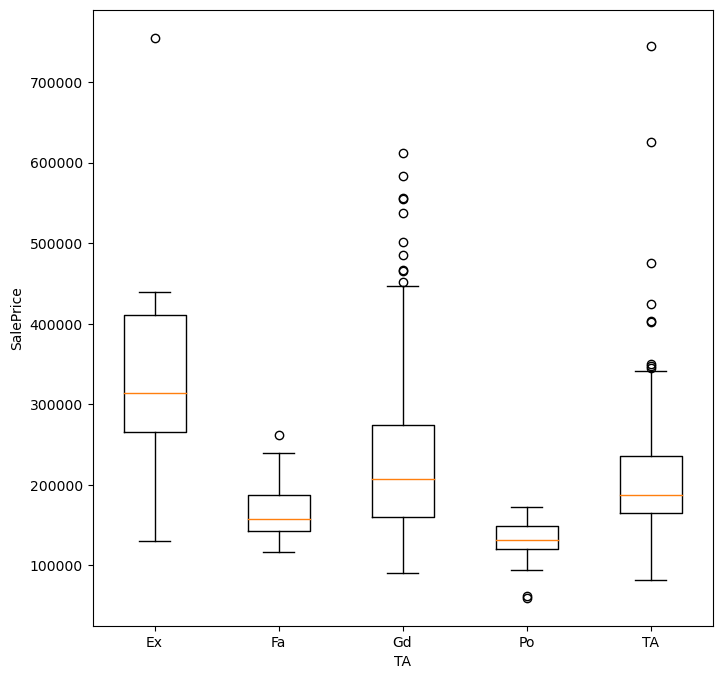

GarageType


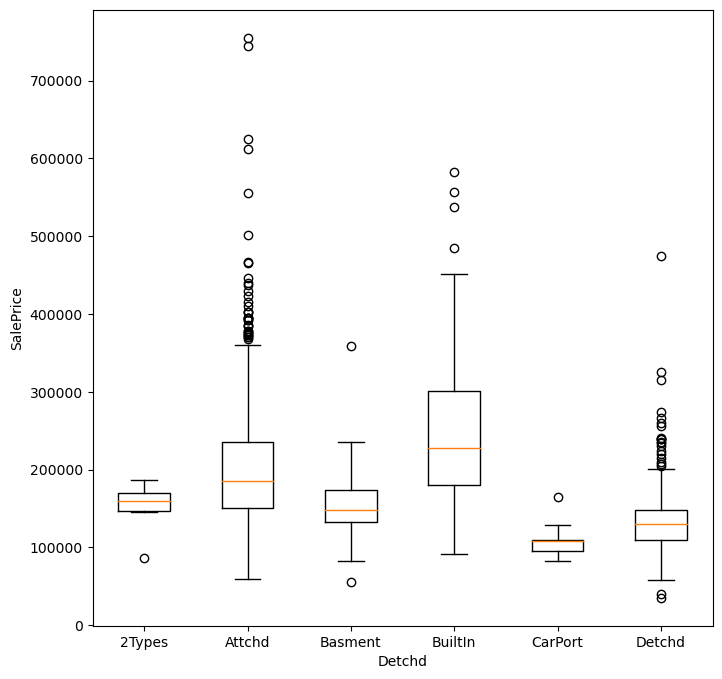

In [11]:
def plot_categorical(grouped,label,figsize=(12,8)):
    plt.figure(figsize=figsize)
    labels=[]
    data=[]
    for name,group in grouped:
        labels.append(name)
        data.append(group[label])
    plt.boxplot(data,labels=labels)
    plt.xlabel(name)
    plt.ylabel(label)
    plt.show()
if plot:
    for f in int_cat_f:
        grouped=train.groupby(f)
        print(f)
        plot_categorical(grouped,label=label,figsize=(8,8))

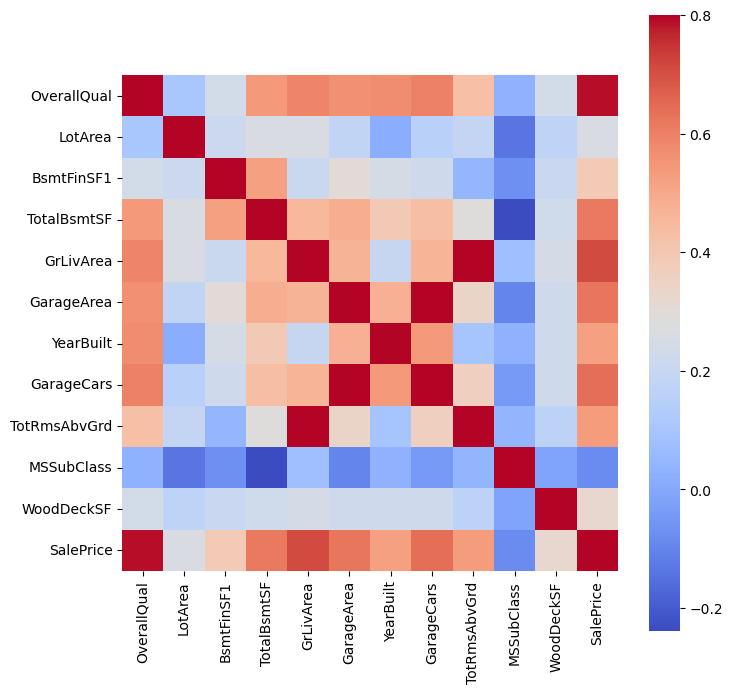

In [7]:

corrmat = train[int_num_f+[label]].corr(numeric_only=True)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="coolwarm")
plt.show()

### First implementation: only using numeric features and model.fit() method

In [6]:
feat_eng(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,1710,2.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,1262,1.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,1786,2.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,1717,2.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,2198,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,175000,1647,2.0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,2,2010,WD,Normal,210000,2073,1.0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,GdPrv,Shed,2500,5,2010,WD,Normal,266500,2340,2.0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2010,WD,Normal,142125,1078,1.0


### Excercise 2: preprocess by using keras functional API

1) Build the preprocessing model, passing data as dict

2) numerical features should be normalized

3) categorical features should be one hot encoded

In [7]:
print(int_cat_f,int_num_f)

['SaleCondition', 'ExterQual', 'Neighborhood', 'KitchenQual', 'SaleType', 'PoolQC', 'MSZoning', 'GarageQual', 'Condition1', 'BldgType', 'FireplaceQu', 'GarageType'] ['OverallQual', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'YearBuilt', 'GarageCars', 'TotRmsAbvGrd', 'MSSubClass', 'WoodDeckSF']


In [8]:
inputs = {}
for name in int_num_f+int_cat_f:
    if name in int_num_f:
        dtype = tf.float32
    if (name in int_cat_f):
        dtype = tf.string
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'OverallQual': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'OverallQual')>,
 'LotArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'LotArea')>,
 'BsmtFinSF1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtFinSF1')>,
 'TotalBsmtSF': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'TotalBsmtSF')>,
 'GrLivArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GrLivArea')>,
 'GarageArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageArea')>,
 'YearBuilt': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'YearBuilt')>,
 'GarageCars': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageCars')>,
 'TotRmsAbvGrd': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'TotRmsAbvGrd')>,
 'MSSubClass': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'MSSubClass')>,
 'WoodDeckSF': <KerasTensor: shape=(None, 1) dtype=float32 (created by l

#### Numeric inputs:

Concatenate the numeric input layers:

In [9]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(train[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 11) dtype=float32 (created by layer 'normalization')>

In [10]:
preprocessed_inputs = [all_numeric_inputs]

#### Categorical inputs

In [11]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = layers.StringLookup(vocabulary=np.unique(train[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

#### Create the preprocessing layer

In [13]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

house_prices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

#tf.keras.utils.plot_model(model = house_prices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

#### Create the model

In [14]:
def create_model(preprocessing_head, inputs:dict):
    preprocessed_inputs = preprocessing_head(inputs)
    x=tf.keras.layers.Dense(100,activation='relu')(preprocessed_inputs)
    x=tf.keras.layers.Dropout(0.3)(x)
    x=tf.keras.layers.Dense(170,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x=tf.keras.layers.Dense(150,activation='relu')(x)
    result = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, result)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

house_price_model = create_model(house_prices_preprocessing, inputs)

In [15]:
print(house_price_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 BldgType (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 BsmtFinSF1 (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Condition1 (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 ExterQual (InputLayer)         [(None, 1)]          0           []                               
                                                                                            

In [16]:
#function to create train and validation dictionaries
def train_val(df:pd.DataFrame,val_fraction,feature_list,label,shuffle=False):
    '''returns the train and validation sets as dictionaries'''
    if shuffle==True:
        df=df.sample(frac=1)
    
    val_size=int(val_fraction*len(df))
    train_size=len(df)-val_size
    print('train size = ', train_size, '\nvalidation size = ', val_size)
    train_df=df.iloc[:train_size]
    val_df=df.iloc[train_size:]
    train_dict={name:np.array(train_df[name]) for name in feature_list}
    val_dict={name:np.array(val_df[name]) for name in feature_list}
    train_label=train_df[label]
    val_label=val_df[label]
    return train_dict,train_label,val_dict,val_label

In [17]:
train_features_dict={name:np.array(train[name]) for name in (int_num_f+int_cat_f)}


In [21]:
split_fraction=0.3

In [19]:
house_prices_preprocessing(train_features_dict)

<tf.Tensor: shape=(1460, 113), dtype=float32, numpy=
array([[ 0.65147984, -0.20714168,  0.57542485, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0718355 , -0.09188636,  1.1719922 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.65147984,  0.07347997,  0.09290722, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.65147984, -0.14781025, -0.36987108, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7951509 , -0.08016039, -0.8655483 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.7951509 , -0.05811154,  0.8473894 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [22]:
history2=house_price_model.fit(x=train_features_dict, y=train[label], epochs=200,batch_size=15,validation_split=split_fraction)

Epoch 1/200
69/69 [==============================] - 7s 61ms/step - loss: 82.5598 - root_mean_squared_error: 198431.3594 - mean_squared_logarithmic_error: 82.5598 - val_loss: 46.4339 - val_root_mean_squared_error: 195326.2500 - val_mean_squared_logarithmic_error: 46.4339
Epoch 2/200
69/69 [==============================] - 3s 41ms/step - loss: 34.2744 - root_mean_squared_error: 197952.8125 - mean_squared_logarithmic_error: 34.2744 - val_loss: 24.7857 - val_root_mean_squared_error: 194430.7188 - val_mean_squared_logarithmic_error: 24.7857
Epoch 3/200
69/69 [==============================] - 2s 33ms/step - loss: 19.8936 - root_mean_squared_error: 196547.0000 - mean_squared_logarithmic_error: 19.8936 - val_loss: 15.3694 - val_root_mean_squared_error: 192417.7969 - val_mean_squared_logarithmic_error: 15.3694
Epoch 4/200
69/69 [==============================] - 3s 40ms/step - loss: 12.8166 - root_mean_squared_error: 193928.9062 - mean_squared_logarithmic_error: 12.8166 - val_loss: 10.2620 -

### Make predictions and score

In [23]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test).flatten()
    print(predictions.shape)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    print(z)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

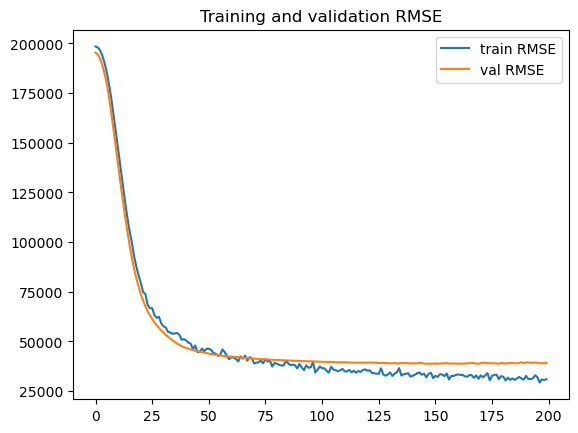

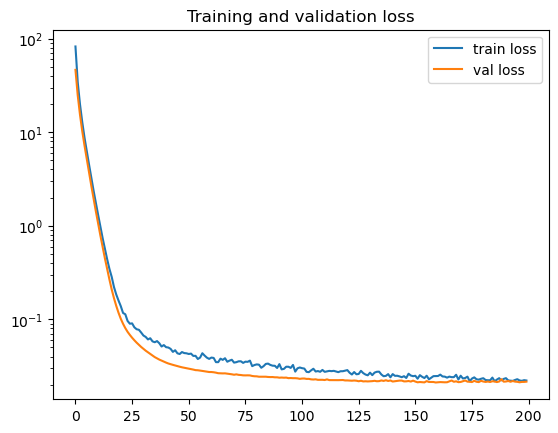

In [24]:
metric = history2.history['root_mean_squared_error']
val_metric = history2.history['val_root_mean_squared_error']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(metric))

plt.plot(epochs, metric,label='train RMSE')
plt.plot(epochs, val_metric,label='val RMSE')
plt.title('Training and validation RMSE')
plt.legend()
plt.figure()

plt.plot(epochs, loss,label='train loss')
plt.plot(epochs, val_loss,label='val loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
_,_,val_features_dict,val_label=train_val(train,0.2,(int_num_f+int_cat_f),label=label,shuffle=False)

train size =  1168 
validation size =  292


10/10 [==============================] - 1s 17ms/step
(292,)
r2 coefficient:  0.7000813730992592 
msle =  0.0242537706842669
[7.96403003e-01 3.89283164e+04]


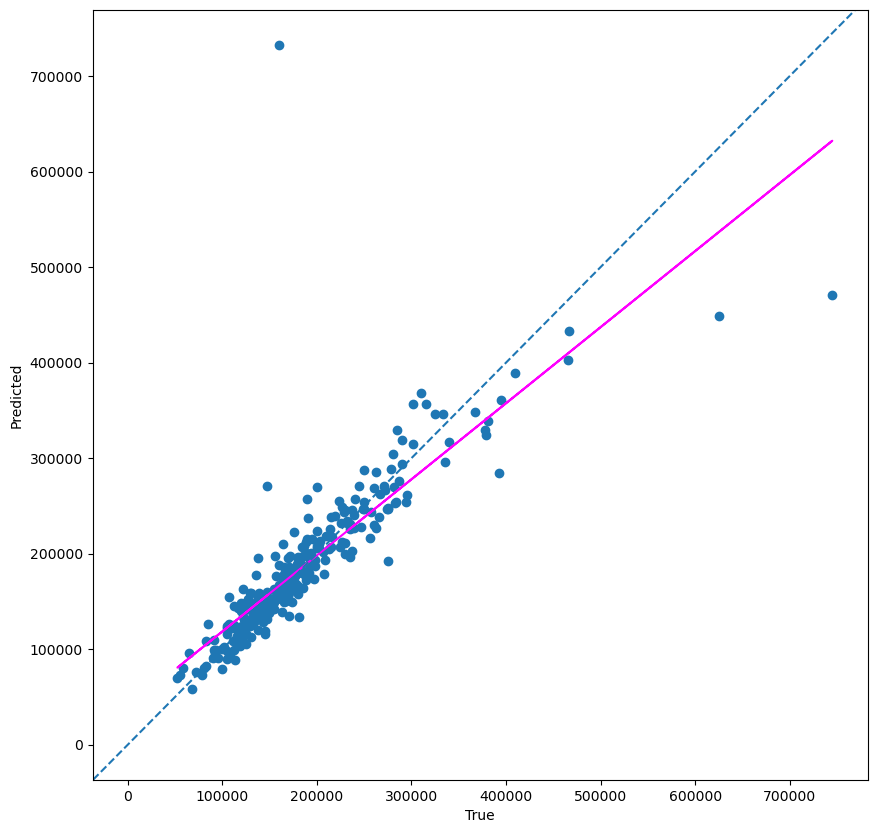

In [26]:
score_and_visualize(model=house_price_model,x_test=val_features_dict,y_test=val_label)


Save predictions

In [27]:
import datetime

In [ ]:
if IN_KAGGLE:
    test_path='../input/house-prices-advanced-regression-techniques/test.csv'
else:
    test_path='./test.csv'

In [28]:
write=True

test=pd.read_csv(test_path)

NameError: name 'model' is not defined

In [ ]:
test=feat_eng(test)
test[int_cat_f]=test[int_cat_f].fillna('none')
test[int_num_f]=test[int_num_f].fillna(-1)

In [ ]:
test_feature_dict={name:np.array(test[name]) for name in (int_num_f+int_cat_f)}
for name in int_num_f:
    test_feature_dict[name]=tf.cast(test_feature_dict[name],tf.float32)

for name in int_cat_f:
    test_feature_dict[name]=tf.cast(test_feature_dict[name],tf.string)

pred=house_price_model.predict(test_feature_dict)
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction_tf_allfeatures.csv',index=False)

Save model

In [ ]:
savemodel=False
if savemodel:
    timestamp=datetime.datetime.now().strftime("%d%m%Y%H%M%S")
    models_folder= 'models'
    os.makedirs(models_folder,exist_ok=True)
    model_name= 'model_'+ timestamp +'_tf.h5'
    modelpath= os.path.join(models_folder,model_name)
    house_price_model.save(modelpath)
    print('Saved ' , modelpath)